In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date is: {most_recent_date[0]}")

The most recent date is: 2017-08-23


The date one year ago from the last date is: 2016-08-23 00:00:00


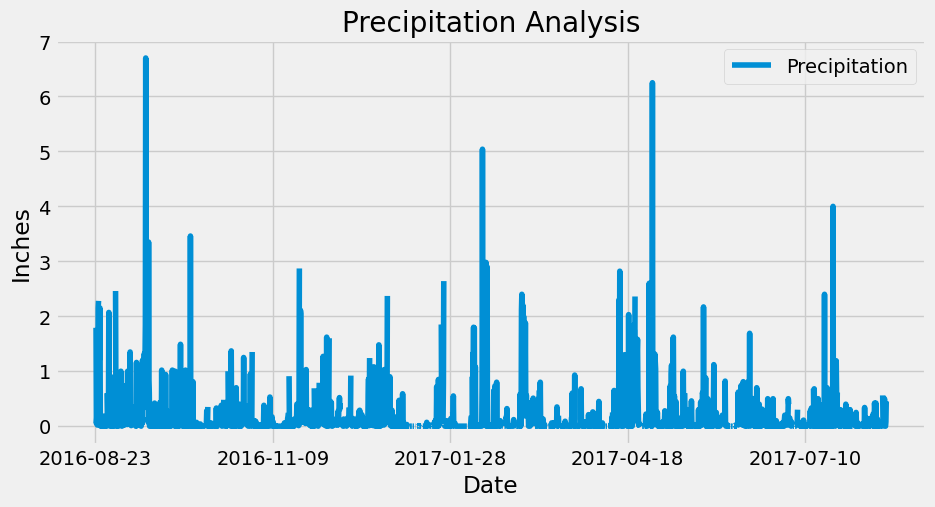

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d") - relativedelta(years=1)
print(f"The date one year ago from the last date is: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query_results = session.query(*sel).filter(Measurement.date >= one_year_ago.date()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(query_results, columns=["Date", "Precipitation"])
precipitation_df.set_index("Date", inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()

summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
print(f"Total number of stations: {total_stations[0][0]}")

Total number of stations: 9


In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())
print("Stations and Counts in descending order:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Stations and Counts in descending order:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


Station **USC00519281** has the greatest number of observations.

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {temps[0][0]}, High: {temps[0][1]}, Average: {round(temps[0][2], 1)}")

Most Active Station Temperatures
Low: 54.0, High: 85.0, Average: 71.7


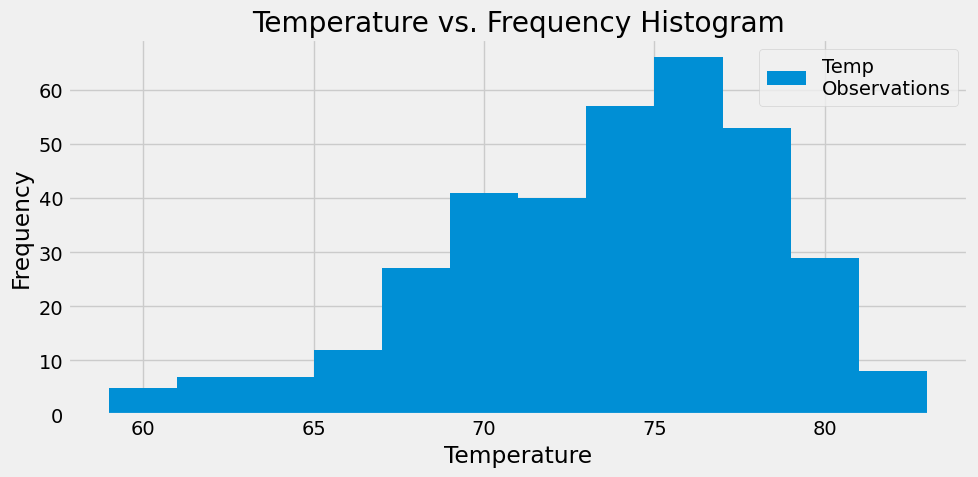

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago.date()).\
    filter(Measurement.station == most_active_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=["Temp\nObservations"])

temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()

# Close Session

In [54]:
# Close Session
session.close()